In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer    
from nltk.tokenize import RegexpTokenizer
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from scipy.sparse import hstack

import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("MoviesOnStreamingPlatforms_updated.csv")
data = data.iloc[:, 1:]

In [3]:
data.head()

,ID,Title,Year,Age,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,1,The Irishman,2019,18+,7.8/10,98/100,1,0,0,0,0,Martin Scorsese,"Biography,Crime,Drama",United States,"English,Italian,Latin,Spanish,German",209.0
1,2,Dangal,2016,7+,8.4/10,97/100,1,0,0,0,0,Nitesh Tiwari,"Action,Biography,Drama,Sport","India,United States,United Kingdom,Australia,K...","Hindi,English",161.0
2,3,David Attenborough: A Life on Our Planet,2020,7+,9.0/10,95/100,1,0,0,0,0,"Alastair Fothergill,Jonathan Hughes,Keith Scholey","Documentary,Biography",United Kingdom,English,83.0
3,4,Lagaan: Once Upon a Time in India,2001,7+,8.1/10,94/100,1,0,0,0,0,Ashutosh Gowariker,"Drama,Musical,Sport","India,United Kingdom","Hindi,English",224.0
4,5,Roma,2018,18+,7.7/10,94/100,1,0,0,0,0,NaN,"Action,Drama,History,Romance,War","United Kingdom,United States",English,52.0


In [4]:
data.info()
# some column in the wrong dtype, we will convert them after missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9515 entries, 0 to 9514
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               9515 non-null   int64  
 1   Title            9515 non-null   object 
 2   Year             9515 non-null   int64  
 3   Age              5338 non-null   object 
 4   IMDb             9309 non-null   object 
 5   Rotten Tomatoes  9508 non-null   object 
 6   Netflix          9515 non-null   int64  
 7   Hulu             9515 non-null   int64  
 8   Prime Video      9515 non-null   int64  
 9   Disney+          9515 non-null   int64  
 10  Type             9515 non-null   int64  
 11  Directors        9104 non-null   object 
 12  Genres           9399 non-null   object 
 13  Country          9261 non-null   object 
 14  Language         9202 non-null   object 
 15  Runtime          9196 non-null   float64
dtypes: float64(1), int64(7), object(8)
memory usage: 1.2+ MB


Missing Values

In [5]:
data_size = len(data)
miss_sum = data.isnull().sum()
sorted_miss_sum = pd.Series.sort_values(miss_sum, ascending = False)
pct_miss_sum = (sorted_miss_sum / data_size) * 100
print(pct_miss_sum)

Age                43.899107
Directors           4.319496
Runtime             3.352601
Language            3.289543
Country             2.669469
IMDb                2.165003
Genres              1.219128
Rotten Tomatoes     0.073568
Type                0.000000
Disney+             0.000000
Prime Video         0.000000
Hulu                0.000000
Netflix             0.000000
Year                0.000000
Title               0.000000
ID                  0.000000
dtype: float64


In [6]:
# Drop Age due to the huge pct of missing values
data.drop(pct_miss_sum.index[0], axis = 1, inplace = True)
data.dropna(subset = pct_miss_sum.index[pct_miss_sum > 0][1:], inplace = True)
data.reset_index(inplace = True, drop = True)

# Check if theres any missing value left
data.isnull().any()

ID                 False
Title              False
Year               False
IMDb               False
Rotten Tomatoes    False
Netflix            False
Hulu               False
Prime Video        False
Disney+            False
Type               False
Directors          False
Genres             False
Country            False
Language           False
Runtime            False
dtype: bool

In [7]:
# transform the values in IMDb and Rotten Tomatoes since 
# they having unexpected data - e.g. (7.8/10)
def division(content):
    val1, val2 = content.split("/")
    divide = float(val1) / int(val2)
    return divide

data["IMDb"] = data["IMDb"].map(division)
data["Rotten Tomatoes"] = data["Rotten Tomatoes"].map(division)
data.head()

,ID,Title,Year,IMDb,Rotten Tomatoes,Netflix,Hulu,Prime Video,Disney+,Type,Directors,Genres,Country,Language,Runtime
0,1,The Irishman,2019,0.78,0.98,1,0,0,0,0,Martin Scorsese,"Biography,Crime,Drama",United States,"English,Italian,Latin,Spanish,German",209.0
1,2,Dangal,2016,0.84,0.97,1,0,0,0,0,Nitesh Tiwari,"Action,Biography,Drama,Sport","India,United States,United Kingdom,Australia,K...","Hindi,English",161.0
2,3,David Attenborough: A Life on Our Planet,2020,0.90,0.95,1,0,0,0,0,"Alastair Fothergill,Jonathan Hughes,Keith Scholey","Documentary,Biography",United Kingdom,English,83.0
3,4,Lagaan: Once Upon a Time in India,2001,0.81,0.94,1,0,0,0,0,Ashutosh Gowariker,"Drama,Musical,Sport","India,United Kingdom","Hindi,English",224.0
4,6,To All the Boys I've Loved Before,2018,0.71,0.94,1,0,0,0,0,Susan Johnson,"Comedy,Drama,Romance",United States,English,99.0


In [8]:
# Convert year to object
data.Year = data.Year.astype("object")
# Conver imdb and rotten tomatoes to float
data.IMDb = data.IMDb.astype("float64")
data["Rotten Tomatoes"] = data["Rotten Tomatoes"].astype("float64")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8695 entries, 0 to 8694
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8695 non-null   int64  
 1   Title            8695 non-null   object 
 2   Year             8695 non-null   object 
 3   IMDb             8695 non-null   float64
 4   Rotten Tomatoes  8695 non-null   float64
 5   Netflix          8695 non-null   int64  
 6   Hulu             8695 non-null   int64  
 7   Prime Video      8695 non-null   int64  
 8   Disney+          8695 non-null   int64  
 9   Type             8695 non-null   int64  
 10  Directors        8695 non-null   object 
 11  Genres           8695 non-null   object 
 12  Country          8695 non-null   object 
 13  Language         8695 non-null   object 
 14  Runtime          8695 non-null   float64
dtypes: float64(3), int64(6), object(6)
memory usage: 1019.1+ KB


Visualization

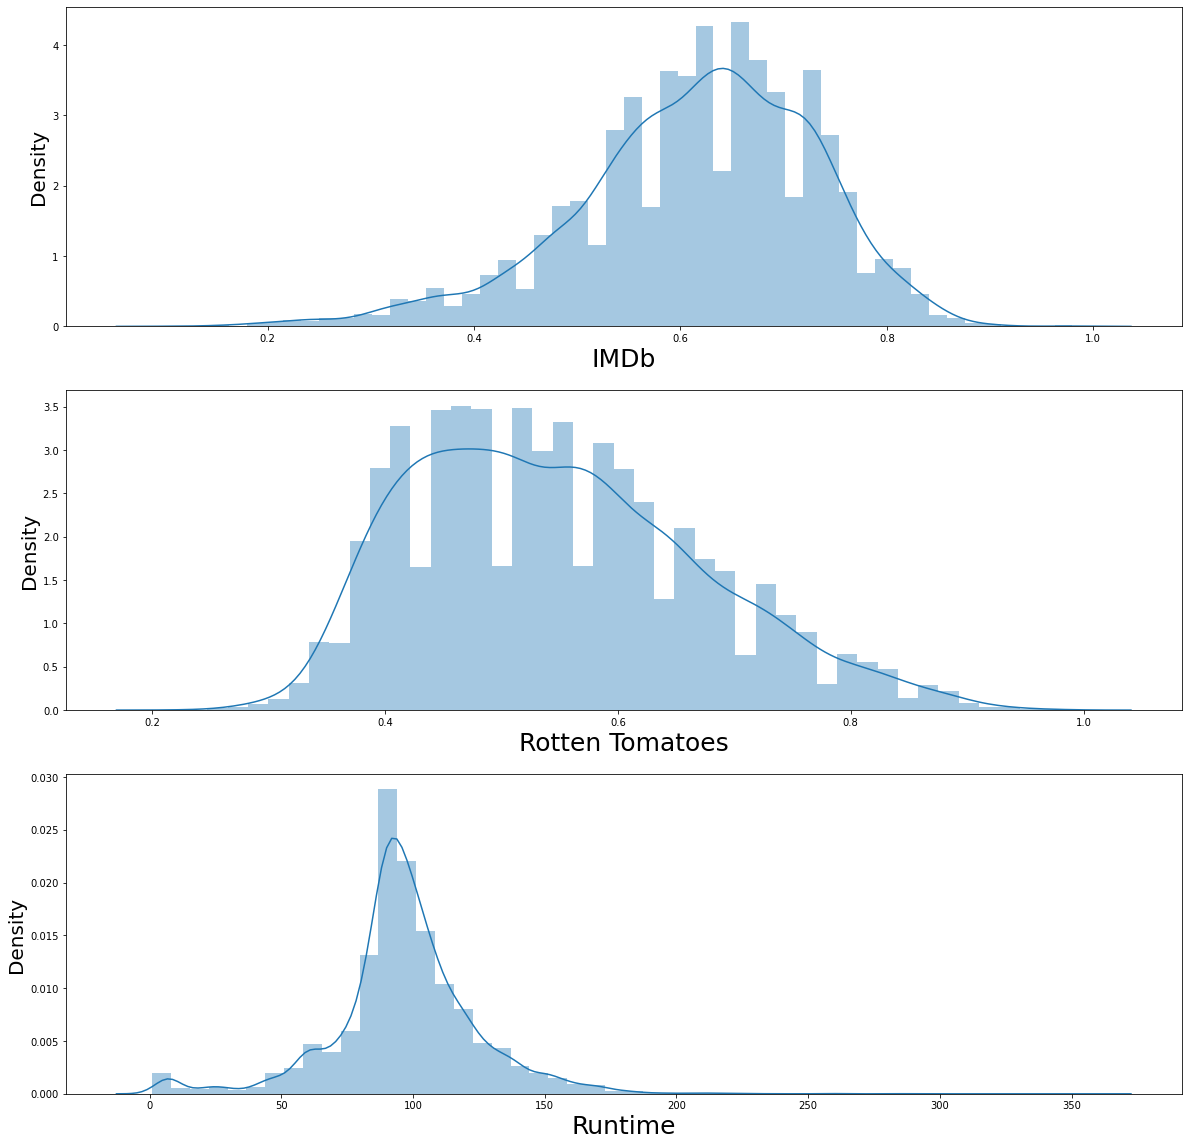

In [9]:
# Check the distribution
cols = ["IMDb", "Rotten Tomatoes", "Runtime"]

# Dist plot
fig = plt.figure(figsize = (20,20))
ax1 = fig.add_subplot(3, 1, 1)
sns.distplot(data[cols[0]])
ax1.set_xlabel("IMDb", fontsize = 25)
ax1.set_ylabel("Density", fontsize = 20)

ax2 = fig.add_subplot(3, 1, 2)
sns.distplot(data[cols[1]])
ax2.set_xlabel("Rotten Tomatoes", fontsize = 25)
ax2.set_ylabel("Density", fontsize = 20)

ax3 = fig.add_subplot(3, 1, 3)
sns.distplot(data[cols[2]])
ax3.set_xlabel("Runtime", fontsize = 25)
ax3.set_ylabel("Density", fontsize = 20)

plt.show()

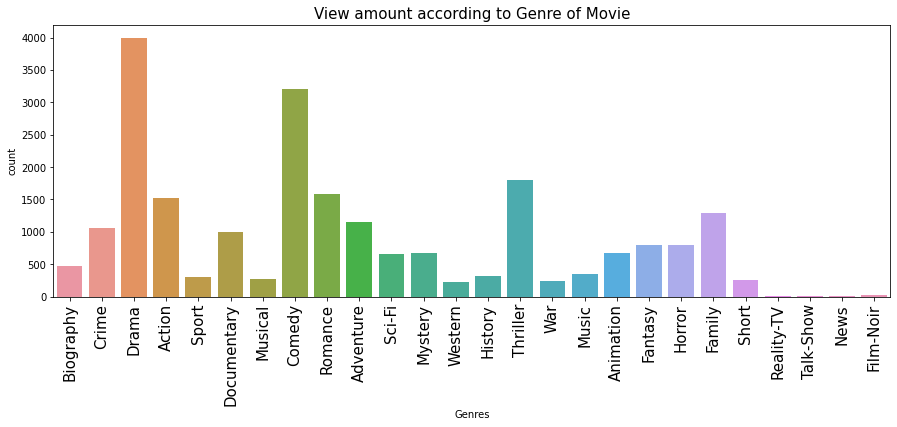

In [10]:
temp = data.copy()

# Split the Genres by ',' & and stack it one after the other for easy analysis.
genres = temp['Genres'].str.split(',').apply(pd.Series).stack()
genres.index = genres.index.droplevel(-1)
genres.name = 'Genres'

# delete column - prevent confliction
transformed = temp.drop("Genres", axis = 1)

# join new column with the existing dataframe
genres = transformed.join(genres)

# Visualization
plt.figure(figsize=(15,5))
plt.title("View amount according to Genre of Movie", fontsize = 15)
sns.countplot(x='Genres', data=genres)
plt.xticks(rotation=90, fontsize = 15)
plt.show()

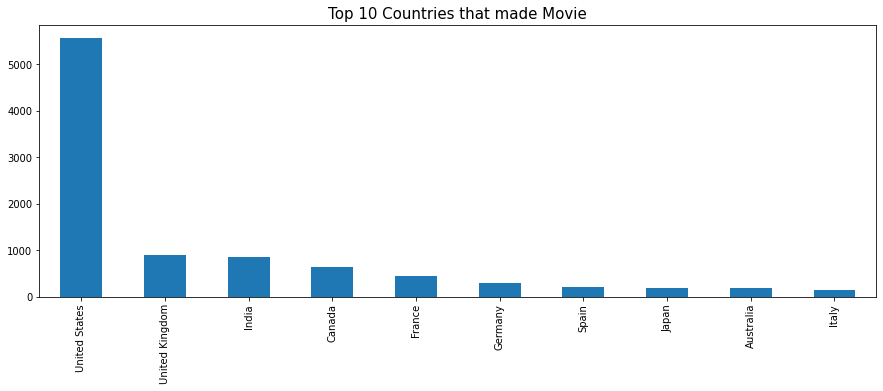

In [11]:
temp = data.copy()

# Split the Country by ',' & and stack it one after the other for easy analysis.
country = temp['Country'].str.split(',').apply(pd.Series).stack()
country.index = country.index.droplevel(-1)
country.name = 'Country'

# delete column - prevent confliction
transformed = temp.drop("Country", axis = 1)

# join new column with the existing dataframe
country = transformed.join(country)

# Visualization
plt.title("Top 10 Countries that made Movie", fontsize = 15)
country["Country"].value_counts()[:10].plot(kind = 'bar', figsize = (15,5))
plt.show()

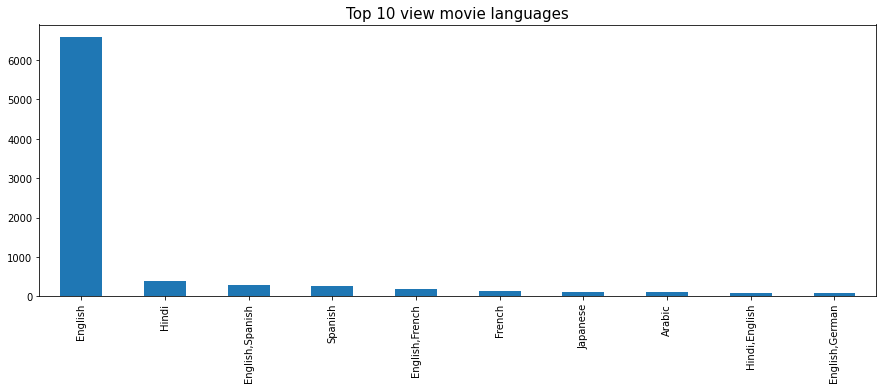

In [12]:
temp = data.copy()

# Split the Language by ',' & then stack it one after the other for easy analysis.
language = temp['Language'].str.split(',').apply(pd.Series).stack()
language.index = language.index.droplevel(-1)
language.name = 'Language'

# delete column - prevent confliction
transformed = temp.drop("Language", axis = 1)

# join new column with the existing dataframe
language = transformed.join(language)

# Visualization
plt.title("Top 10 view movie languages", fontsize = 15)
country["Language"].value_counts()[:10].plot(kind = 'bar', figsize = (15,5))
plt.show()

In [13]:
# Visualize IMDb across each platform
platform_df = pd.melt(temp, id_vars=["ID","Title","Year","IMDb","Type","Runtime"], 
                      var_name = 'Platform')
platform_df = platform_df[platform_df.value == 1]
platform_df.head()

,ID,Title,Year,IMDb,Type,Runtime,Platform,value
8695,1,The Irishman,2019,0.78,0,209.0,Netflix,1
8696,2,Dangal,2016,0.84,0,161.0,Netflix,1
8697,3,David Attenborough: A Life on Our Planet,2020,0.90,0,83.0,Netflix,1
8698,4,Lagaan: Once Upon a Time in India,2001,0.81,0,224.0,Netflix,1
8699,6,To All the Boys I've Loved Before,2018,0.71,0,99.0,Netflix,1


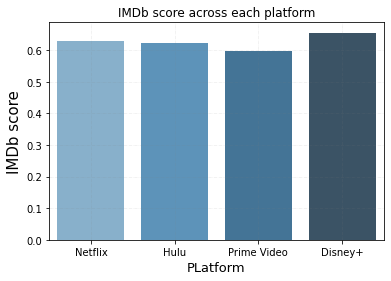

In [14]:
platform = platform_df["Platform"].unique()
imdb_score = []
# calculate mean of imdb score across each platform
for ptf in platform:
    imdb_score.append(platform_df[platform_df["Platform"] == ptf]["IMDb"].mean())

color = ["maroon", "blue", "gray", "black"]
sns.barplot(x=platform, y=imdb_score, palette="Blues_d")
plt.title("IMDb score across each platform", fontsize = 12)
plt.xlabel("PLatform", fontsize = 13)
plt.ylabel("IMDb score", fontsize = 15)
plt.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
plt.show()

Recommendation System

In [15]:
def preprocess(df):
    # Preprocess object data
    object_list = list(df.select_dtypes(include=['object']).columns)
    # Removing ID and Title column
    object_list.remove("Title")
    object_list.remove("Year")
    # Joining all text in the object columns
    df['all_text']= df[object_list].apply(lambda x: ','.join(x.dropna().astype(str)),axis=1)

    # Tokenizer
    token = RegexpTokenizer(r'[a-zA-Z]+')

    # Converting TfidfVector from the text
    vectorizer = TfidfVectorizer(lowercase=True,stop_words='english',
                         ngram_range = (1,1),tokenizer = token.tokenize)
    text_data = vectorizer.fit_transform(df['all_text'])

    
    # Preproess numerical data
    ndf = df.select_dtypes(include=['float64',"int64"])

    # Applying scaler on our data and converting i into a data frame
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    ndfmx = pd.DataFrame((scaler.fit_transform(ndf)), columns = ndf.columns)   

    # Adding the numerical data into the vectorizer
    for column in ndfmx.columns:
        # apply 2d array
        col = ndfmx[column].values[:, np.newaxis]
        finalized_data = hstack((text_data, col))

    return finalized_data

In [16]:
pre_data = preprocess(data)
pre_data.shape

(8695, 8185)

In [17]:
# Compute the cosine similarity
csine = cosine_similarity(pre_data, pre_data)
post_data = pd.Series(data.index, index=data['Title']).drop_duplicates()
post_data.head()

Title
The Irishman                                0
Dangal                                      1
David Attenborough: A Life on Our Planet    2
Lagaan: Once Upon a Time in India           3
To All the Boys I've Loved Before           4
dtype: int64

In [18]:
def recommendation(title, csine, post_data):
    # Get the index corresponding to original_title
    idx = post_data[title]
    # Get the cosine similarity scores
    scores = list(enumerate(csine[idx]))

    # Sort the movies
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    # Scores of the 10 most similar movies
    top10_scores = sorted_scores[1:11]

    # Movie indices
    movie_indices = [score[0] for score in top10_scores]
    movie_name = post_data[movie_indices]
    return pd.DataFrame(np.array(movie_name.index), columns = ['Movie'])

In [19]:
recommendation("Dangal", csine, post_data)

,Movie
0,Chillar Party
1,Love per Square Foot
2,Lagaan: Once Upon a Time in India
3,No Direction Home: Bob Dylan
4,Bareilly's Barfi
5,Mully
6,Mary Kom
7,Soorma
8,Dhan Dhana Dhan Goal
9,Ammonite
